# Causal ML, Uplift Modeling Part 1

## Import Libraries & Data

In [161]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklift.metrics import uplift_at_k,qini_auc_score
from sklift.datasets import fetch_hillstrom # our dataset!
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import optuna
from sklearn.metrics import roc_auc_score, log_loss
from causalml.metrics import auuc_score
import seaborn as sns
import shap
import statsmodels.api as sm

In [162]:
# Load Hillstrom dataset
def load_hillstrom(target,print_info=True):
    dataset = fetch_hillstrom(target_col=target)
    df = dataset.data
    # Segment has 3 options, womens email, mens email and no email, so we can create 'treatment' by choosing one of the two treatments here
    df['segment'] = dataset.treatment
    # There are 3 outcomes, visit, conversion and spend, we can choose one of them as our target
    df[target] = dataset.target
    if print_info:
        print("Show me the top of the dataset\n")
        print(df.head())
        print("\n\n\n")
        print("Are there any null values in this dataframe?\n")
        print(df.isna().sum())
        print("\n\n\n")
        print("What does the dataframe look like? What datatypes are the features?\n")
        print(df.info())
    return df

data = load_hillstrom(target='visit')
df = data.copy()

Show me the top of the dataset

   recency history_segment  history  mens  womens   zip_code  newbie channel  \
0       10  2) $100 - $200   142.44     1       0  Surburban       0   Phone   
1        6  3) $200 - $350   329.08     1       1      Rural       1     Web   
2        7  2) $100 - $200   180.65     0       1  Surburban       1     Web   
3        9  5) $500 - $750   675.83     1       0      Rural       1     Web   
4        2    1) $0 - $100    45.34     1       0      Urban       0     Web   

         segment  visit  
0  Womens E-Mail      0  
1      No E-Mail      0  
2  Womens E-Mail      0  
3    Mens E-Mail      0  
4  Womens E-Mail      0  




Are there any null values in this dataframe?

recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
segment            0
visit              0
dtype: int64




What does the dataframe look like? What datatypes are 

In [163]:
data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0


## Explore Data

In [164]:
# The treatment
df['segment'].value_counts()

segment
Womens E-Mail    21387
Mens E-Mail      21307
No E-Mail        21306
Name: count, dtype: int64

In [165]:
# Let's just use men's email first and create a treatment variable to 1/0 the treatment/control
df = df.loc[df['segment'].isin(['Mens E-Mail','No E-Mail'])]
df['treatment'] = df['segment'].map({'Mens E-Mail':1,'No E-Mail':0})
df['treatment'].value_counts(normalize=True)

treatment
1    0.500012
0    0.499988
Name: proportion, dtype: float64

In [166]:
# This dataset has visit, conversion, and revenue as the target variables, we are going to use visit as the target variable
df['target'] = df['visit'].copy()
df['target'].value_counts()

target
0    36457
1     6156
Name: count, dtype: int64

In [167]:
# Customer purchased mens merchandise in the past year
df['mens'].value_counts()

mens
1    23526
0    19087
Name: count, dtype: int64

In [168]:
# Customer purchased womens merchandise in the past year
df['womens'].value_counts()

womens
1    23417
0    19196
Name: count, dtype: int64

In [169]:
# Only a few customers purchased from both mens and womens merch in the past year
df.groupby(['mens','womens']).size()

mens  womens
0     1         19087
1     0         19196
      1          4330
dtype: int64

In [170]:
# segments for TTM spend
df['history_segment'].value_counts()

history_segment
1) $0 - $100        15336
2) $100 - $200       9527
3) $200 - $350       8134
4) $350 - $500       4221
5) $500 - $750       3249
6) $750 - $1,000     1266
7) $1,000 +           880
Name: count, dtype: int64

In [171]:
# Define conditions and corresponding values
conditions = [
    df['history_segment'].isin(['1) $0 - $100', '2) $100 - $200']),
    df['history_segment'].isin(['3) $200 - $350', '4) $350 - $500', '5) $500 - $750'])
]
choices = ['low', 'medium']

# Apply conditions to create the new column
df['history_bins'] = np.select(conditions, choices, default='high')

df['history_bins'].value_counts()


history_bins
low       24863
medium    15604
high       2146
Name: count, dtype: int64

In [172]:
df.groupby('history_bins')['target'].mean()

history_bins
high      0.198509
low       0.121546
medium    0.173545
Name: target, dtype: float64

In [173]:
# Actual TTM spend
df['history'].describe()

count    42613.000000
mean       241.859315
std        256.574723
min         29.990000
25%         64.500000
50%        157.000000
75%        325.210000
max       3345.930000
Name: history, dtype: float64

In [174]:
# Months since last purchase
df['recency'].value_counts()

recency
1     5934
2     5074
10    5022
9     4330
3     3899
4     3406
6     3048
5     2985
7     2720
8     2337
11    2316
12    1542
Name: count, dtype: int64

In [175]:
# New custome in past year
df['newbie'].value_counts()

newbie
1    21381
0    21232
Name: count, dtype: int64

In [176]:
# TTM purchase channels - must be an old dataset given the phone count
df['channel'].value_counts()

channel
Web             18863
Phone           18567
Multichannel     5183
Name: count, dtype: int64

In [177]:
# Classifies urban rural and suburban
df['zip_code'].value_counts()

zip_code
Surburban    19126
Urban        17105
Rural         6382
Name: count, dtype: int64

In [178]:
# Binarize the zip code and channel variables
df = pd.get_dummies(df, columns=['zip_code'], drop_first=True, dtype=int)  # Encode categorical variable
df = pd.get_dummies(df, columns=['channel'], drop_first=True, dtype=int)  # Encode categorical variable
# df = pd.get_dummies(df, columns=['history_segment'], drop_first=True, dtype=int)  # Encode categorical variable
df['recency_bins'] = np.where(df['recency'].between(1,4),'low',np.where(df['recency'].between(5,8),'medium','high'))
df = pd.get_dummies(df, columns=['recency_bins'], drop_first=True, dtype=int)  # Encode categorical variable
df = pd.get_dummies(df, columns=['history_bins'], drop_first=True, dtype=int)  # Encode categorical variable
df = df.drop(columns=['segment','visit','history','recency','history_segment']) # Drop unnecessary features

In [179]:
df = df.rename(columns={'history_segment_2) $100 - $200':'history_segment_100_200',
                        'history_segment_3) $200 - $350':'history_segment_200_350',
                        'history_segment_4) $350 - $500':'history_segment_350_500',
                        'history_segment_5) $500 - $750':'history_segment_500_750',
                        'history_segment_6) $750 - $1,000':'history_segment_750_1000',
                        'history_segment_7) $1,000 +':'history_segment_1000_plus'})

In [180]:
# One grand view of our final dataset! Looks ready for modeling.
df.head()

,mens,womens,newbie,treatment,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,recency_bins_low,recency_bins_medium,history_bins_low,history_bins_medium
1,1,1,1,0,0,0,0,0,1,0,1,0,1
3,1,0,1,1,0,0,0,0,1,0,0,0,1
8,1,1,1,1,0,0,0,1,0,0,0,0,1
13,0,1,0,1,1,0,1,0,1,1,0,1,0
14,0,1,1,0,0,0,0,0,0,1,0,0,1


In [181]:
# It appears everything is just about equal in terms of the treatment group and the control group for feature means, except the target which is ok
df.groupby('treatment').mean()

# Even if it wasn't, we could still run the model using the covariates as features, but would need to adjust for the imbalance in the treatment groups

,mens,womens,newbie,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,recency_bins_low,recency_bins_medium,history_bins_low,history_bins_medium
treatment,,,,,,,,,,,,
0,0.553224,0.547639,0.501971,0.106167,0.451751,0.400920,0.437764,0.439923,0.429879,0.263682,0.584249,0.367033
1,0.550946,0.551415,0.501525,0.182757,0.445910,0.401887,0.433660,0.445394,0.429624,0.256817,0.582672,0.365326


## Campaign Analysis

- Which e-mail campaign performed the best, the Mens version, or the Womens version?
- How much incremental sales per customer did the Mens version of the e-mail campaign drive? How much incremental sales per customer did the Womens version of the e-mail campaign drive?
- If you could only send an e-mail campaign to the best 10,000 customers, which customers would receive the e-mail campaign? Why?
- If you had to eliminate 10,000 customers from receiving an e-mail campaign, which customers would you suppress from the campaign? Why?
- Did the Mens version of the e-mail campaign perform different than the Womens version of the e-mail campaign, across various customer segments?
- Did the campaigns perform different when measured across different metrics, like Visitors, Conversion, and Total Spend?
- Did you observe any anomalies, or odd findings?
- Which audience would you target the Mens version to, and the Womens version to, given the results of the test? What data do you have to support your recommendation?

In [182]:
data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0


### Which e-mail campaign performed the best, the Mens version, or the Womens version?

In [183]:
data.groupby('segment')['visit'].value_counts(normalize=True).reset_index()

,segment,visit,proportion
0,Mens E-Mail,0,0.817243
1,Mens E-Mail,1,0.182757
2,No E-Mail,0,0.893833
3,No E-Mail,1,0.106167
4,Womens E-Mail,0,0.848600
5,Womens E-Mail,1,0.151400


In [184]:
mens = data.loc[data['segment']=='Mens E-Mail']['visit'].mean()
womens = data.loc[data['segment']=='Womens E-Mail']['visit'].mean()
no_email = data.loc[data['segment']=='No E-Mail']['visit'].mean()

mens_lift = (mens - no_email) / no_email
womens_lift = (womens - no_email) / no_email

print(f"Men's email lift: {mens_lift*100}")
print(f"Women's email lift: {womens_lift*100}")

Men's email lift: 72.1404616781399
Women's email lift: 42.60550702669102


In [185]:
data = load_hillstrom(target='conversion',print_info=False)
mens = data.loc[data['segment']=='Mens E-Mail']['conversion'].mean()
womens = data.loc[data['segment']=='Womens E-Mail']['conversion'].mean()
no_email = data.loc[data['segment']=='No E-Mail']['conversion'].mean()

mens_lift = (mens - no_email) / no_email
womens_lift = (womens - no_email) / no_email

print(f"Men's email lift: {mens_lift*100}")
print(f"Women's email lift: {womens_lift*100}")

Men's email lift: 118.84218762863279
Women's email lift: 54.33130436982172


In [186]:
data = load_hillstrom(target='spend',print_info=False)
mens = data.loc[data['segment']=='Mens E-Mail']['spend'].mean()
womens = data.loc[data['segment']=='Womens E-Mail']['spend'].mean()
no_email = data.loc[data['segment']=='No E-Mail']['spend'].mean()

mens_lift = mens - no_email
womens_lift = womens - no_email

print(f"Men's email lift: {mens_lift}")
print(f"Women's email lift: {womens_lift}")

Men's email lift: 0.7698271558945367
Women's email lift: 0.4244122159365966


The mens email performed better in visits, conversion, and spend.

### How much incremental sales per customer did the Mens version of the e-mail campaign drive? How much incremental sales per customer did the Womens version of the e-mail campaign drive?

In [187]:
data = load_hillstrom(target='spend',print_info=False)
mens = data.loc[data['segment']=='Mens E-Mail']['spend'].mean()
womens = data.loc[data['segment']=='Womens E-Mail']['spend'].mean()
no_email = data.loc[data['segment']=='No E-Mail']['spend'].mean()

mens_lift = mens - no_email
womens_lift = womens - no_email

print(f"Men's email lift: {mens_lift}")
print(f"Women's email lift: {womens_lift}")

Men's email lift: 0.7698271558945367
Women's email lift: 0.4244122159365966


In [188]:
data = load_hillstrom(target='spend',print_info=False)
data = data.loc[data['spend']>0]
mens = data.loc[data['segment']=='Mens E-Mail']['spend'].mean()
womens = data.loc[data['segment']=='Womens E-Mail']['spend'].mean()
no_email = data.loc[data['segment']=='No E-Mail']['spend'].mean()

mens_lift = mens - no_email
womens_lift = womens - no_email

print(f"Men's email lift: {mens_lift}")
print(f"Women's email lift: {womens_lift}")

Men's email lift: -0.47577607908147
Women's email lift: 7.892056986729116


For those who purchased, the Women's email cusotmers spent them most, followed by the no email customers, then the men's email customers.
It appears that the conversion rate lift for the men is high enough to offset any decrease in spend per customer.

## Feature Engineering to improve model

In [189]:
df.head()

,mens,womens,newbie,treatment,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,recency_bins_low,recency_bins_medium,history_bins_low,history_bins_medium
1,1,1,1,0,0,0,0,0,1,0,1,0,1
3,1,0,1,1,0,0,0,0,1,0,0,0,1
8,1,1,1,1,0,0,0,1,0,0,0,0,1
13,0,1,0,1,1,0,1,0,1,1,0,1,0
14,0,1,1,0,0,0,0,0,0,1,0,0,1


### Difference in visit rates given treatment and given control in different areas of the feature

In [190]:
for i in df.columns.to_list():
    if i not in ['treatment','target']:
        data = df.groupby(['treatment',i]).agg({'target':'mean'}).reset_index()
        diff_on = data.loc[(data['treatment']==1)&(data[i]==1)]['target'].values[0] - data.loc[(data['treatment']==0)&(data[i]==1)]['target'].values[0]
        diff_off = data.loc[(data['treatment']==1)&(data[i]==0)]['target'].values[0] - data.loc[(data['treatment']==0)&(data[i]==0)]['target'].values[0]
        # print(data)
        # print(diff_on)
        # print(diff_off)
        print(f"Feature {i} has a difference in means of {diff_on-diff_off:.2f}")
        print(f"Feature {i} has a treatment effect of {(diff_on-diff_off)/diff_off*100:.2f}%")

Feature mens has a difference in means of 0.01
Feature mens has a treatment effect of 15.57%
Feature womens has a difference in means of 0.01
Feature womens has a treatment effect of 19.38%
Feature newbie has a difference in means of -0.00
Feature newbie has a treatment effect of -3.25%
Feature zip_code_Surburban has a difference in means of -0.00
Feature zip_code_Surburban has a treatment effect of -5.02%
Feature zip_code_Urban has a difference in means of 0.01
Feature zip_code_Urban has a treatment effect of 6.81%
Feature channel_Phone has a difference in means of -0.00
Feature channel_Phone has a treatment effect of -1.94%
Feature channel_Web has a difference in means of -0.00
Feature channel_Web has a treatment effect of -2.11%
Feature recency_bins_low has a difference in means of 0.01
Feature recency_bins_low has a treatment effect of 20.23%
Feature recency_bins_medium has a difference in means of -0.01
Feature recency_bins_medium has a treatment effect of -17.27%
Feature history_

### Variable Means by treatment and target

In [191]:
for i in df.columns.to_list():
    print(df.groupby(['treatment','target']).agg({i:'mean'}))

                      mens
treatment target          
0         0       0.548047
          1       0.596817
1         0       0.541951
          1       0.591166
                    womens
treatment target          
0         0       0.544423
          1       0.574713
1         0       0.543847
          1       0.585259
                    newbie
treatment target          
0         0       0.517328
          1       0.372679
1         0       0.519095
          1       0.422958
                  treatment
treatment target           
0         0             0.0
          1             0.0
1         0             1.0
          1             1.0
                  target
treatment target        
0         0          0.0
          1          1.0
1         0          0.0
          1          1.0
                  zip_code_Surburban
treatment target                    
0         0                 0.455367
          1                 0.421309
1         0                 0.451042
          1

### Graph out mean target by treatment and feature

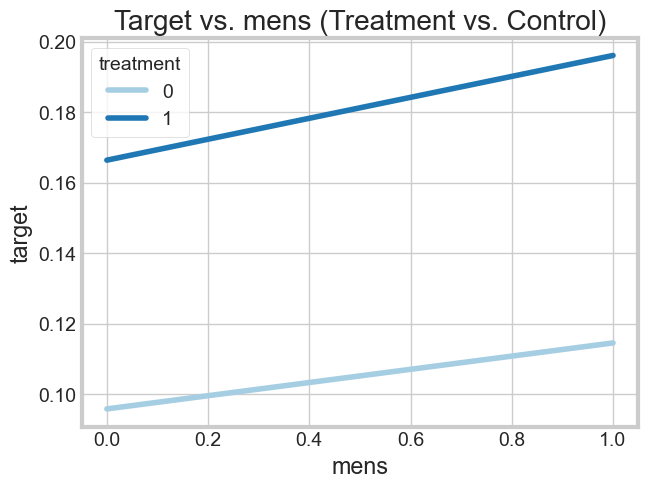

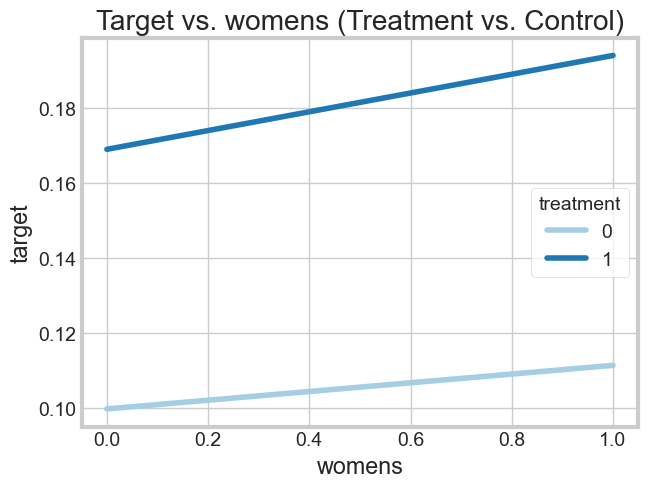

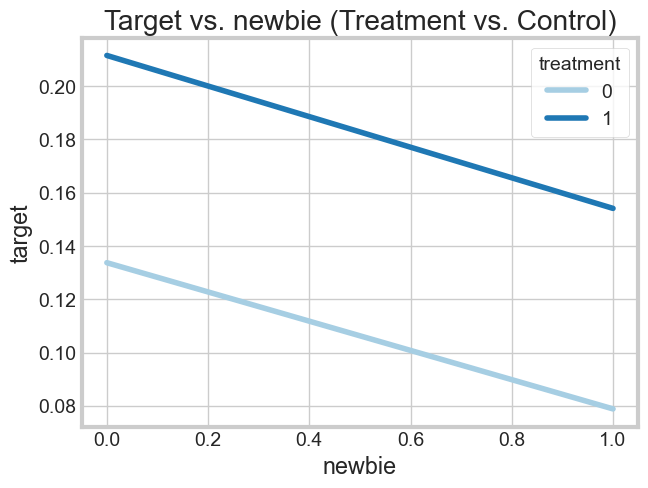

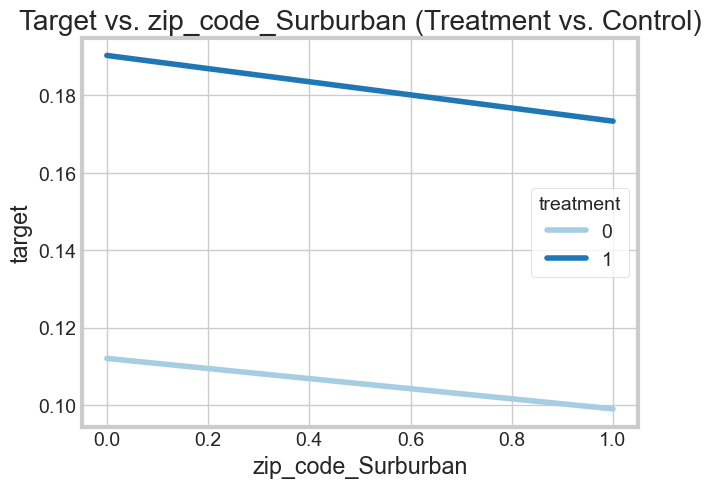

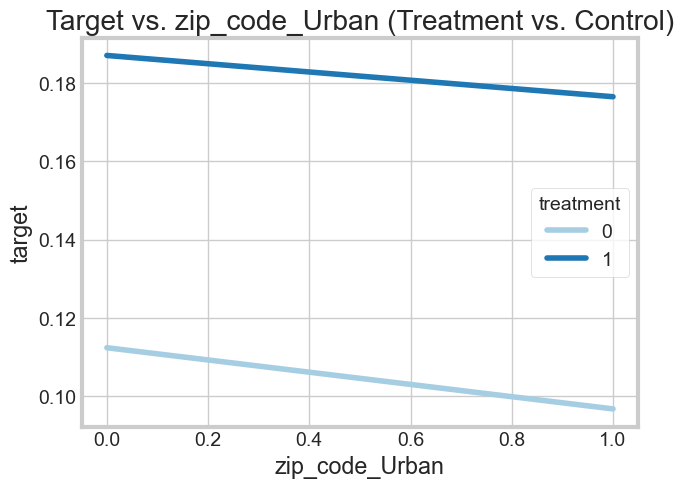

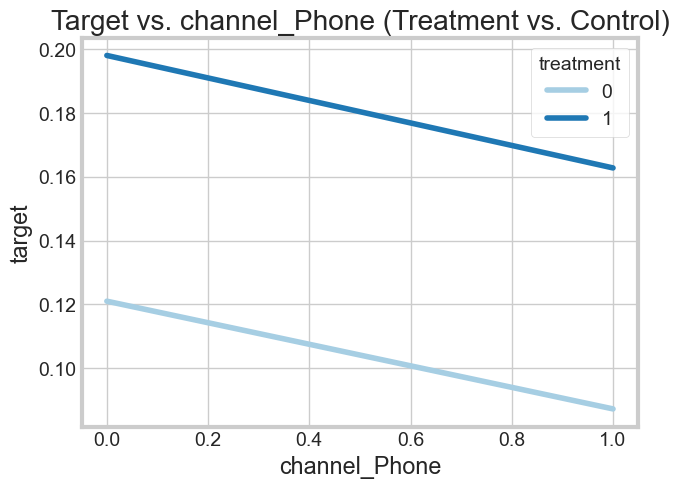

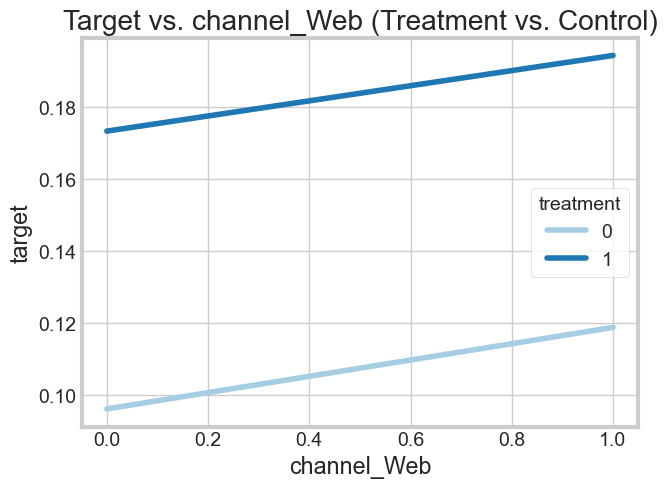

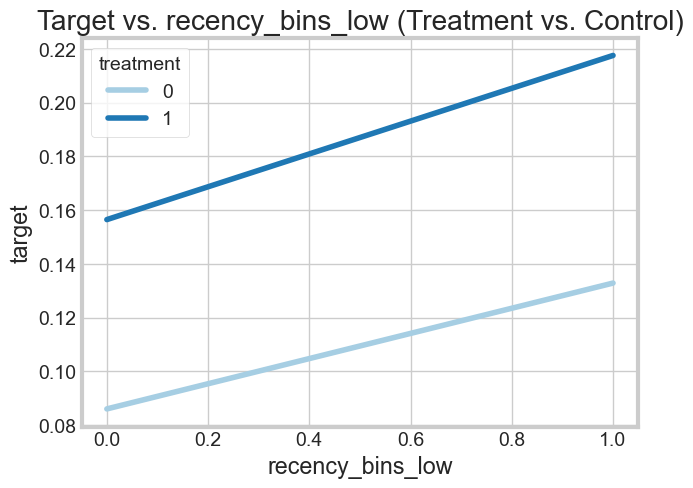

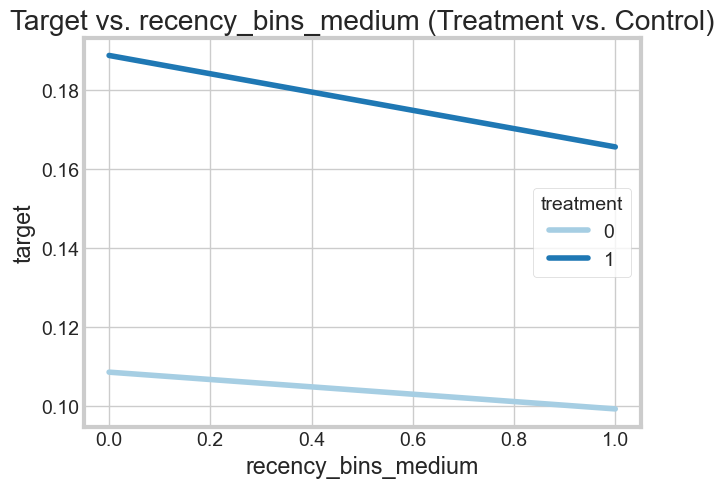

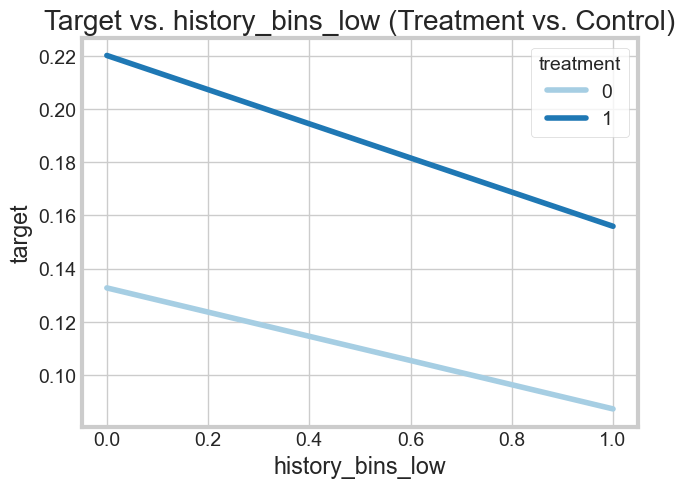

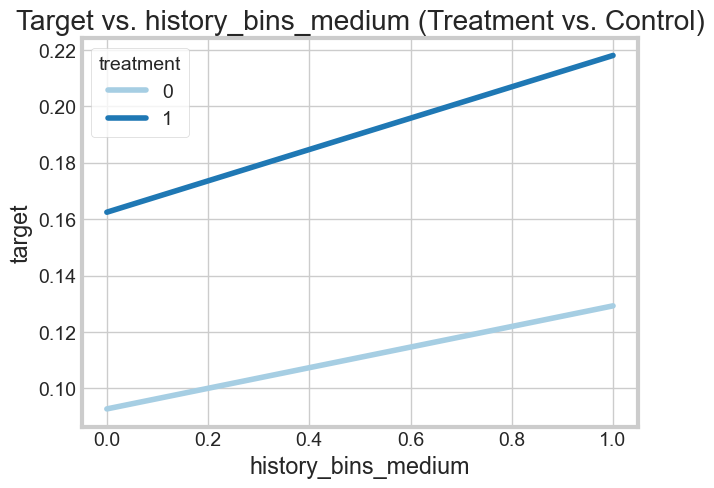

In [192]:
for i in df.columns.to_list():
    if i not in ['treatment','target']:
        # Calculate mean outcomes by recency
        summary = df.groupby(['treatment', i]).agg({'target': 'mean'}).reset_index()

        # Plot outcomes for treatment and control groups
        sns.lineplot(data=summary, x=i, y='target', hue='treatment')
        plt.title(f'Target vs. {i} (Treatment vs. Control)')
        plt.show()

### Create interaction features and test using logistic regression

In [200]:
# Create interaction features

# Hypothesis: Zip code urban will perform better than zip code rural or suburban given the treatment
df['zip_code_Urban_treatment'] = df['zip_code_Urban'] * df['treatment']
df['channel_Phone_treatment'] = df['channel_Phone'] * df['treatment']
df['history_bins_medium_treatment'] = df['history_bins_medium'] * df['treatment']
df['recency_bins_low_treatment'] = df['recency_bins_low'] * df['treatment']
df['newbie_mens'] = df['newbie'] * df['mens']
df['newbie_womens'] = df['newbie'] * df['womens']


# Final feature list
varlist = [
    'treatment',
    'mens',
    'womens',
    'newbie',
    'recency_bins_low',
    'recency_bins_medium',
    'history_bins_low',
    'history_bins_medium',
    'zip_code_Surburban',
	'zip_code_Urban',
	'channel_Phone',
    'channel_Web',

    # 'newbie_mens',
    # 'newbie_womens',

    # 'history_segment_100_200',
    # 'history_segment_200_350',
    # 'history_segment_350_500',
    # 'history_segment_500_750',
    # 'history_segment_750_1000',
    # 'history_segment_1000_plus',
    
    # 'zip_code_Urban_treatment',
    # 'channel_Phone_treatment',
    # 'history_bins_medium_treatment',
    # 'recency_bins_low_treatment',
]

df_updated = df[varlist + ['target']]

# run quick regression to see coefficients
sm.Logit(df_updated['target'], sm.add_constant(df_updated[varlist])).fit().summary()

# df_control = df_updated.loc[df_updated['treatment'] == 0]
# df_treatment = df_updated.loc[df_updated['treatment'] == 1]
# X_control = df_control[varlist]
# y_control = df_control['target']
# X_treatment = df_treatment[varlist]
# y_treatment = df_treatment['target']
# sm.Logit(y_control, sm.add_constant(X_control)).fit().summary()
# sm.Logit(y_treatment, sm.add_constant(X_treatment)).fit().summary()

Optimization terminated successfully.
         Current function value: 0.392734
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                42613
Model:                          Logit   Df Residuals:                    42599
Method:                           MLE   Df Model:                           13
Date:                Sun, 29 Dec 2024   Pseudo R-squ.:                 0.04903
Time:                        15:17:50   Log-Likelihood:                -16736.
converged:                       True   LL-Null:                       -17598.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.1839      0.105    -20.741      0.000      -2.390      -1.978
treatment               0.6471      0.029     22.406      0.000       0.590       0.704
mens                    0.6531      0.047     13.992      0.000       0.562       0.745
womens                  0.5868      0.053     10.976      0.000       0.482       0.692
newbie                 -0.6261      0.045    -14.017      0.000      -0.714      -0.539
recency_bins_low        0.4716      0.035     13.479      0.000       0.403       0.540
recency_bins_medium     0.1678      0.040      4.192      0.000       0.089       0.246
history_bins_low       -0.4774      0.068     -7.039      0.000      -0.610      -0.344
history_bins_medium    -0.2706      0.063     -4.271      0.000      -0.395      -0.146
zip_code_Surburban     -0.4011      0.039    -10.260      0.000      -0.478      -0.324
zip_code_Urban         -0.4052      0.040    -10.191      0.000      -0.483      -0.327
channel_Phone          -0.0872      0.048     -1.820      0.069      -0.181       0.007
channel_Web             0.1830      0.047      3.889      0.000       0.091       0.275
newbie_womens           0.0948      0.058      1.625      0.104      -0.020       0.209
=======================================================================================
"""

### Test out features using quick model to see if the score increases

In [194]:
df.head()

,mens,womens,newbie,treatment,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,recency_bins_low,recency_bins_medium,history_bins_low,history_bins_medium,zip_code_Urban_treatment,channel_Phone_treatment,history_bins_medium_treatment,recency_bins_low_treatment
1,1,1,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0
3,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0
8,1,1,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0
13,0,1,0,1,1,0,1,0,1,1,0,1,0,1,0,0,1
14,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [195]:
# Quick model test
def build_quick_model():
    # Params from winning model below
    treatment_params = {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.9386706273100895}
    control_params = {'n_estimators': 121, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 0.8348869401494565}

    # Final feature list
    varlist = [
        'treatment',
        'mens',
        'womens',
        'newbie',
        'recency_bins_low',
        'recency_bins_medium',
        'history_bins_low',
        'history_bins_medium',
        'zip_code_Surburban',
        'zip_code_Urban',
        'channel_Phone',
        'channel_Web',
    ]

    # Train test split
    X = df[varlist]
    y = df['target']
    t = df['treatment']
    X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(X, y, t, test_size=0.25)

    # Split datasets into treatment and control models
    X_treatment = X_train[t_train == 1]
    y_treatment = y_train[t_train == 1]
    X_control = X_train[t_train == 0]
    y_control = y_train[t_train == 0]
    X_test_treatment = X_test[t_test == 1]
    y_test_treatment = y_test[t_test == 1]
    X_test_control = X_test[t_test == 0]
    y_test_control = y_test[t_test == 0]

    # Train random forest on treatment and control groups
    t_model = RandomForestClassifier(**treatment_params)
    c_model = RandomForestClassifier(**control_params)
    t_model.fit(X_treatment, y_treatment)
    c_model.fit(X_control, y_control)

    # Make predictions on test sets for treatment and control
    y_pred_treatment = t_model.predict_proba(X_test_treatment)[:, 1]
    y_pred_control = c_model.predict_proba(X_test_control)[:, 1]

    # Calculate model metrics
    print("Treatment Model")
    print(f'ROC AUC: {roc_auc_score(y_test_treatment, y_pred_treatment)}')
    print(f'Log Loss: {log_loss(y_test_treatment, y_pred_treatment)}')
    print("")
    print("Control Model")
    print(f'ROC AUC: {roc_auc_score(y_test_control, y_pred_control)}')
    print(f'Log Loss: {log_loss(y_test_control, y_pred_control)}')
    print("")
    
    # Calculate uplift scores
    uplift_treatment_scores = t_model.predict_proba(X_test)[:, 1]
    uplift_control_scores = c_model.predict_proba(X_test)[:, 1]
    uplift_scores = uplift_treatment_scores - uplift_control_scores
    results_df = pd.DataFrame({
        'y_true': y_test,               # Actual outcomes
        'treatment': t_test,            # Treatment indicators
        'uplift_model': uplift_scores,         # Uplift predictions from Random Forest
    })
    auuc_calc = auuc_score(
        df=results_df,
        outcome_col="y_true",
        treatment_col="treatment",
        treatment_effect_col=None
        )
    print(auuc_calc)

    # Let's try sklift's qini auc score
    qini_score = qini_auc_score(y_test, uplift_scores, t_test)

    comparison_df = pd.DataFrame({
        'Model': ['Two-Model RF'],
        'Qini Score': [qini_score]
    })
    print("\n### Qini Score Comparison ###")
    print(comparison_df)

    return t_model, c_model, X_test

t_model,c_model, X_test = build_quick_model()

Treatment Model
ROC AUC: 0.615715923289119
Log Loss: 0.47421138289375003

Control Model
ROC AUC: 0.6322502073158184
Log Loss: 0.3084404382039814

uplift_model    0.545889
Random          0.509911
dtype: float64

### Qini Score Comparison ###
          Model  Qini Score
0  Two-Model RF    0.031972


### Shapley values assessment

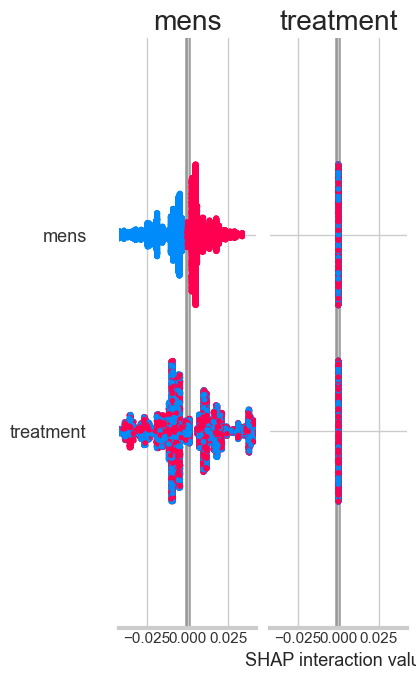

In [196]:
# Train treatment and control models
shap_treatment = shap.TreeExplainer(t_model).shap_values(X_test)
shap_control = shap.TreeExplainer(c_model).shap_values(X_test)

# Compute uplift SHAP values
uplift_shap = np.array(shap_treatment) - np.array(shap_control)

# Visualize feature importance
shap.summary_plot(uplift_shap, X_test)

## Split Train Test Treatment

In [93]:
# Split data into train/test
def split_data(df):
    X = df.drop(columns=['treatment', 'target'])
    y = df['target']
    treatment = df['treatment']
    return train_test_split(X, y, treatment, test_size=0.3)

X_train, X_test, y_train, y_test, t_train, t_test = split_data(df)

## Run Two-Model and Single-Model Approaches

In [94]:
# Model Optimization with Optuna
def optimize_model(trial, X, y, model_type):
    # Set the hyperparameters to optimize and the ranges for xgboost
    if model_type == 'xgboost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
        }
        model = XGBClassifier(**params, eval_metric='logloss')
        # Even though the eval metric for xgboost is logloss, we are evaluating the hyperparameters on maximizing AUC
    # Set the hyperparameters to optimize the ranges for random forest
    elif model_type == 'random_forest':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
        }
        model = RandomForestClassifier(**params)
    else:
        raise ValueError("Unsupported model type")

    scores = cross_val_score(model, X, y, cv=3, scoring='roc_auc')
    return np.mean(scores)

In [95]:
# Run Optuna for Both Models
def run_optuna(X, y, model_type, model_seg, n_trials=50):
    # Create a study object to maximize the AUC
    study = optuna.create_study(direction='maximize')
    # optimize the study based on the input parameters
    study.optimize(lambda trial: optimize_model(trial, X, y, model_type), n_trials=n_trials)
    print(f"Best parameters for {model_type} for {model_seg}: {study.best_params}")
    return study.best_params

In [96]:
# Train and Evaluate Models
def train_and_evaluate(X_train, X_test, y_train, y_test, params, model_type, model_seg):
    # We'll look at xgboost and random forest, this is to train the final mdoel after optuna works it's magic
    if model_type == 'xgboost':
        model = XGBClassifier(**params,  eval_metric='logloss')
    elif model_type == 'random_forest':
        model = RandomForestClassifier(**params)
    else:
        raise ValueError("Unsupported model type")

    # Fit the model and predict probabilities on the test dataset
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    # Grab the AUC & LogLoss metrics for the best model
    auc = roc_auc_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred)
    print(f"{model_type} AUC for {model_seg}: {auc:.4f}\n{model_type} Log Loss for {model_seg}: {logloss:.4f}")
    return model,y_pred

In [97]:
# Optimize and Train Separate Models for Two-Model Approach
def two_model_approach_with_optuna(X_train, X_test, y_train, y_test, t_train):
    
    # Use function run_optuna to optimize the treatment model for xgboost and random forest adn return the optimal hyperparameters

    # Optimize treatment model for xgboost and random forest
    X_treatment = X_train[t_train == 1]
    y_treatment = y_train[t_train == 1]
    params_treatment_xgboost = run_optuna(X_treatment, y_treatment, 'xgboost','treatment')
    params_treatment_randomforest = run_optuna(X_treatment, y_treatment, 'random_forest','treatment')

    # Optimize control model for xgboost and random forest
    X_control = X_train[t_train == 0]
    y_control = y_train[t_train == 0]
    params_control_xgboost = run_optuna(X_control, y_control, 'xgboost','control')
    params_control_randomforest = run_optuna(X_control, y_control, 'random_forest','control')


    # Optimize single model for xgboost and random forest
    X_single_train = X_train.copy()
    X_single_train['treatment'] = t_train
    X_single_test_1 = X_test.copy()
    X_single_test_1['treatment'] = 1
    X_single_test_0 = X_test.copy()
    X_single_test_0['treatment'] = 0
    params_single_xgboost = run_optuna(X_single_train, y_train, 'xgboost','single')
    params_single_randomforest = run_optuna(X_single_train, y_train, 'random_forest','single')

    # Train final models using function train_and_evaluate
    model_treatment_xgboost,preds_treatment_xgboost = train_and_evaluate(X_treatment, X_test, y_treatment, y_test, params_treatment_xgboost, 'xgboost','treatment')
    model_treatment_randomforest,preds_treatment_randomforest = train_and_evaluate(X_treatment, X_test, y_treatment, y_test, params_treatment_randomforest, 'random_forest','treatment')
    model_control_xgboost,preds_control_xgboost = train_and_evaluate(X_control, X_test, y_control, y_test, params_control_xgboost, 'xgboost','control')
    model_control_randomforest,preds_control_randomforest = train_and_evaluate(X_control, X_test, y_control, y_test, params_control_randomforest, 'random_forest','control')
    model_single_1_xgboost,preds_single_1_xgboost = train_and_evaluate(X_single_train, X_single_test_1, y_train, y_test, params_single_xgboost, 'xgboost','single_1')
    model_single_1_randomforest,preds_single_1_randomforest = train_and_evaluate(X_single_train, X_single_test_1, y_train, y_test, params_single_randomforest, 'random_forest','single_1')
    model_single_0_xgboost,preds_single_0_xgboost = train_and_evaluate(X_single_train, X_single_test_0, y_train, y_test, params_single_xgboost, 'xgboost','single_0')
    model_single_0_randomforest,preds_single_0_randomforest = train_and_evaluate(X_single_train, X_single_test_0, y_train, y_test, params_single_randomforest, 'random_forest','single_0')

    return model_treatment_xgboost, preds_treatment_xgboost, model_treatment_randomforest, preds_treatment_randomforest, model_control_xgboost, preds_control_xgboost, model_control_randomforest, preds_control_randomforest, model_single_1_xgboost, preds_single_1_xgboost, model_single_1_randomforest, preds_single_1_randomforest, model_single_0_xgboost, preds_single_0_xgboost, model_single_0_randomforest, preds_single_0_randomforest

In [98]:
%%time
# Execute the Two-Model Approach with Optuna usng function "two_model_approach_with_optuna"
model_treatment_xgboost, preds_treatment_xgboost, model_treatment_randomforest, preds_treatment_randomforest, model_control_xgboost, preds_control_xgboost, model_control_randomforest, preds_control_randomforest, model_single_1_xgboost, preds_single_1_xgboost, model_single_1_randomforest, preds_single_1_randomforest, model_single_0_xgboost, preds_single_0_xgboost, model_single_0_randomforest, preds_single_0_randomforest = two_model_approach_with_optuna(X_train, X_test, y_train, y_test, t_train)

[I 2024-12-29 14:18:43,482] A new study created in memory with name: no-name-2ac964b8-2bf1-4ab0-bf9e-0a5b0f7dafee
[I 2024-12-29 14:18:43,660] Trial 0 finished with value: 0.6176353224868444 and parameters: {'n_estimators': 118, 'max_depth': 5, 'learning_rate': 0.1970796077187957, 'subsample': 0.7743997004006458, 'colsample_bytree': 0.6316920561669196, 'gamma': 3.8684558180280586}. Best is trial 0 with value: 0.6176353224868444.
[I 2024-12-29 14:18:43,895] Trial 1 finished with value: 0.6138700651692486 and parameters: {'n_estimators': 111, 'max_depth': 4, 'learning_rate': 0.04985258864982164, 'subsample': 0.6854874606268259, 'colsample_bytree': 0.9044988907323718, 'gamma': 0.7077489177515089}. Best is trial 0 with value: 0.6176353224868444.
[I 2024-12-29 14:18:44,168] Trial 2 finished with value: 0.6171646463034733 and parameters: {'n_estimators': 204, 'max_depth': 3, 'learning_rate': 0.038368119884236614, 'subsample': 0.780831693854431, 'colsample_bytree': 0.8757646568869186, 'gamma':

Best parameters for xgboost for treatment: {'n_estimators': 182, 'max_depth': 3, 'learning_rate': 0.1361370168469825, 'subsample': 0.8387629716378774, 'colsample_bytree': 0.7738539640600707, 'gamma': 1.8085891991162377}


[I 2024-12-29 14:18:59,224] Trial 0 finished with value: 0.6097741055202079 and parameters: {'n_estimators': 181, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 0.8660084670892332}. Best is trial 0 with value: 0.6097741055202079.
[I 2024-12-29 14:19:01,089] Trial 1 finished with value: 0.6086176690482555 and parameters: {'n_estimators': 164, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.6054774006057537}. Best is trial 0 with value: 0.6097741055202079.
[I 2024-12-29 14:19:03,924] Trial 2 finished with value: 0.5895969568909435 and parameters: {'n_estimators': 174, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 0.7858199668264647}. Best is trial 0 with value: 0.6097741055202079.
[I 2024-12-29 14:19:04,829] Trial 3 finished with value: 0.6065714201460305 and parameters: {'n_estimators': 96, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 0.6402061088770828}

Best parameters for random_forest for treatment: {'n_estimators': 288, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 0.87678007306503}


[I 2024-12-29 14:22:17,538] Trial 0 finished with value: 0.649144965838414 and parameters: {'n_estimators': 285, 'max_depth': 6, 'learning_rate': 0.018941784734599367, 'subsample': 0.9841608968850589, 'colsample_bytree': 0.9412820333921179, 'gamma': 2.481808324585164}. Best is trial 0 with value: 0.649144965838414.
[I 2024-12-29 14:22:18,477] Trial 1 finished with value: 0.652463409574823 and parameters: {'n_estimators': 217, 'max_depth': 5, 'learning_rate': 0.2545396764080705, 'subsample': 0.683477478586209, 'colsample_bytree': 0.9159152028874185, 'gamma': 3.8909804624543742}. Best is trial 1 with value: 0.652463409574823.
[I 2024-12-29 14:22:19,013] Trial 2 finished with value: 0.6522869510234001 and parameters: {'n_estimators': 68, 'max_depth': 5, 'learning_rate': 0.22743993710770383, 'subsample': 0.8094778357232596, 'colsample_bytree': 0.6973721327893345, 'gamma': 2.282902020135131}. Best is trial 1 with value: 0.652463409574823.
[I 2024-12-29 14:22:19,828] Trial 3 finished with va

Best parameters for xgboost for control: {'n_estimators': 216, 'max_depth': 10, 'learning_rate': 0.08626928754726922, 'subsample': 0.6012448977374489, 'colsample_bytree': 0.9999318812200529, 'gamma': 2.840889547277918}


[I 2024-12-29 14:23:20,147] Trial 0 finished with value: 0.6251050244572203 and parameters: {'n_estimators': 81, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 0.606215667056058}. Best is trial 0 with value: 0.6251050244572203.
[I 2024-12-29 14:23:28,832] Trial 1 finished with value: 0.6254057907748819 and parameters: {'n_estimators': 147, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 0.8990161839800389}. Best is trial 1 with value: 0.6254057907748819.
[I 2024-12-29 14:23:40,106] Trial 2 finished with value: 0.6432526549299192 and parameters: {'n_estimators': 258, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 0.6562646267841905}. Best is trial 2 with value: 0.6432526549299192.
[I 2024-12-29 14:23:43,120] Trial 3 finished with value: 0.6173507358656933 and parameters: {'n_estimators': 57, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.625628435859559}

Best parameters for random_forest for control: {'n_estimators': 213, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 0.7782141372064935}


[I 2024-12-29 14:26:40,673] Trial 0 finished with value: 0.6589058590461053 and parameters: {'n_estimators': 147, 'max_depth': 5, 'learning_rate': 0.10403639471847188, 'subsample': 0.8892061531191496, 'colsample_bytree': 0.8253333334864458, 'gamma': 1.7558539302491534}. Best is trial 0 with value: 0.6589058590461053.
[I 2024-12-29 14:26:41,128] Trial 1 finished with value: 0.6591184887299235 and parameters: {'n_estimators': 94, 'max_depth': 9, 'learning_rate': 0.05137397648003416, 'subsample': 0.625550336659612, 'colsample_bytree': 0.9891587013488011, 'gamma': 3.423091147573068}. Best is trial 1 with value: 0.6591184887299235.
[I 2024-12-29 14:26:41,787] Trial 2 finished with value: 0.6586607127108942 and parameters: {'n_estimators': 268, 'max_depth': 7, 'learning_rate': 0.11192268718148358, 'subsample': 0.7089715432675824, 'colsample_bytree': 0.8015765968783315, 'gamma': 4.333508744826078}. Best is trial 1 with value: 0.6591184887299235.
[I 2024-12-29 14:26:42,782] Trial 3 finished wi

Best parameters for xgboost for single: {'n_estimators': 211, 'max_depth': 4, 'learning_rate': 0.07098569318239466, 'subsample': 0.6302189761276005, 'colsample_bytree': 0.9286186955801361, 'gamma': 3.178644371526835}


[I 2024-12-29 14:27:26,931] Trial 0 finished with value: 0.6314181160923447 and parameters: {'n_estimators': 151, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 0.8838328354568349}. Best is trial 0 with value: 0.6314181160923447.
[I 2024-12-29 14:27:35,117] Trial 1 finished with value: 0.635171503423879 and parameters: {'n_estimators': 186, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 0.6039298322323927}. Best is trial 1 with value: 0.635171503423879.
[I 2024-12-29 14:27:46,501] Trial 2 finished with value: 0.6470901140831294 and parameters: {'n_estimators': 300, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 0.6215926207960611}. Best is trial 2 with value: 0.6470901140831294.
[I 2024-12-29 14:27:57,408] Trial 3 finished with value: 0.6514806735848683 and parameters: {'n_estimators': 258, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 0.8217457755952071}. 

Best parameters for random_forest for single: {'n_estimators': 105, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 0.9608400182932708}
xgboost AUC for treatment: 0.6234
xgboost Log Loss for treatment: 0.4013
random_forest AUC for treatment: 0.6193
random_forest Log Loss for treatment: 0.4020
xgboost AUC for control: 0.6240
xgboost Log Loss for control: 0.4016
random_forest AUC for control: 0.6185
random_forest Log Loss for control: 0.4028
xgboost AUC for single_1: 0.6365
xgboost Log Loss for single_1: 0.3962
random_forest AUC for single_1: 0.6229
random_forest Log Loss for single_1: 0.3998
xgboost AUC for single_0: 0.6373
xgboost Log Loss for single_0: 0.3949
random_forest AUC for single_0: 0.6307
random_forest Log Loss for single_0: 0.3981
CPU times: total: 37min 42s
Wall time: 14min 5s


In [99]:
# Uplift scores
def create_uplift_scores(preds_treatment_xgboost,
                        preds_control_xgboost,
                        preds_treatment_randomforest,
                        preds_control_randomforest,
                        preds_single_1_xgboost,
                        preds_single_1_randomforest,
                        preds_single_0_xgboost,
                        preds_single_0_randomforest):

    uplift_two_model_rf = preds_treatment_randomforest - preds_control_randomforest

    uplift_two_model_xg = preds_treatment_xgboost - preds_control_xgboost

    uplift_single_model_xg = preds_single_1_xgboost - preds_single_0_xgboost
    
    uplift_single_model_rf = preds_single_1_randomforest - preds_single_0_randomforest
    
    return uplift_two_model_rf, uplift_two_model_xg, uplift_single_model_xg, uplift_single_model_rf

uplift_two_model_rf, uplift_two_model_xg, uplift_single_model_xg, uplift_single_model_rf = create_uplift_scores(preds_treatment_xgboost,
                                                                                                                preds_control_xgboost,
                                                                                                                preds_treatment_randomforest,
                                                                                                                preds_control_randomforest,
                                                                                                                preds_single_1_xgboost,
                                                                                                                preds_single_1_randomforest,
                                                                                                                preds_single_0_xgboost,
                                                                                                                preds_single_0_randomforest
                                                                                                                )

## Compare Two-Model Approaches and Single-Model Approaches

### sklift Qini AUC Score

In [100]:
# Let's try sklift's qini auc score
qini_two_model_rf = qini_auc_score(y_test, uplift_two_model_rf, t_test)
qini_two_model_xg = qini_auc_score(y_test, uplift_two_model_xg, t_test)
qini_single_model_rf = qini_auc_score(y_test, uplift_single_model_rf, t_test)
qini_single_model_xg = qini_auc_score(y_test, uplift_single_model_xg, t_test)

comparison_df = pd.DataFrame({
    'Model': ['Two-Model RF', 'Two-Model XG', 'Single-Model RF', 'Single-Model XG'],
    'Qini Score': [qini_two_model_rf, qini_two_model_xg, qini_single_model_rf, qini_single_model_xg]
})
print("\n### Qini Score Comparison ###")
print(comparison_df)

# We can see initially that the XG, despite outperforming the RF on the individual models by a bit, does not outperform the random forest in the uplift model scenario
# The Two-Model RF beats out the single model RF by a little bit as well. Let's continue on.


### Qini Score Comparison ###
             Model  Qini Score
0     Two-Model RF    0.039706
1     Two-Model XG    0.035579
2  Single-Model RF    0.022626
3  Single-Model XG    0.011837


### Manual Qini Score

In [101]:
# Let's now try a manual calculation of the Qini Score
def calculate_uplift_metrics(df,uplift, n_groups=5):
    """
    Calculate common uplift model evaluation metrics.
    
    Parameters:
    y_true: array-like, actual outcome (visits)
    treatment: array-like, treatment indicator (0/1)
    uplift_scores: array-like, predicted uplift scores
    n_groups: int, number of groups for AUUC calculation
    
    Returns:
    dict with uplift metrics
    """
    # Sort by uplift scores
    df = df.sort_values(by=uplift, ascending=False)
    y_true = df['y_true'].values
    treatment = df['treatment'].values
    
    # Calculate cumulative gains
    n_samples = len(y_true)
    group_size = n_samples // n_groups
    
    gains = []
    for i in range(n_groups):
        start_idx = i * group_size
        end_idx = (i + 1) * group_size if i < n_groups - 1 else n_samples
        
        group_treat = treatment[start_idx:end_idx]
        group_outcome = y_true[start_idx:end_idx]
        
        # Calculate treatment and control response rates
        treat_rate = np.mean(group_outcome[group_treat == 1])
        ctrl_rate = np.mean(group_outcome[group_treat == 0])
        
        # Calculate uplift
        uplift = treat_rate - ctrl_rate
        gains.append(uplift)
    
    # Calculate metrics
    metrics = {
        'AUUC': np.trapz(gains) / len(gains),  # Area Under the Uplift Curve
        'Qini': np.sum(gains),  # Qini coefficient
        'top_group_uplift': gains[0],  # Uplift in highest scored group
        'uplift_by_group': gains
    }
    
    return metrics

In [102]:
# Create a dataframe with test results
results_df = pd.DataFrame({
    'y_true': y_test,               # Actual outcomes
    'treatment': t_test,            # Treatment indicators
    'uplift_tm_rf': uplift_two_model_rf,         # Uplift predictions from Random Forest
    'uplift_tm_xg': uplift_two_model_xg,        # Uplift predictions from XGBoost
    'uplift_sm_rf' : uplift_single_model_rf,
    'uplift_sm_xg' : uplift_single_model_xg
})
results_df.head()

,y_true,treatment,uplift_tm_rf,uplift_tm_xg,uplift_sm_rf,uplift_sm_xg
6776,0,0,0.086286,0.096837,0.058927,0.060617
45612,0,0,0.069117,0.090942,0.066282,0.075219
40775,0,1,0.094532,0.069226,0.096019,0.069357
37940,0,0,0.071764,0.064526,0.074278,0.063575
36035,0,0,0.090240,0.085309,0.083998,0.093450


In [103]:
xg_tm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_tm_xg'
   )

rf_tm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_tm_rf'
   )

xg_sm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_sm_xg'
   )

rf_sm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_sm_rf'
   )

In [104]:
print(rf_tm_metrics)
print(xg_tm_metrics)
print(rf_sm_metrics)
print(xg_sm_metrics)
# So here we are seeing the qini scores much higher and more similar.
# The XGBoost models win in this scenario
# For the AUUC, the RF wins for the TM but the XG wins for the SM

{'AUUC': 0.04822206644337064, 'Qini': 0.309447088226813, 'top_group_uplift': 0.08972149270656732, 'uplift_by_group': [0.08972149270656732, 0.05337028410821859, 0.06333720071722393, 0.0560660913814509, 0.04695201931335227]}
{'AUUC': 0.052267595103286844, 'Qini': 0.32759609864112416, 'top_group_uplift': 0.08556333127895185, 'uplift_by_group': [0.08556333127895185, 0.06712125813249409, 0.06078898271798901, 0.06716961154126133, 0.04695291497042785]}
{'AUUC': 0.049375182104448814, 'Qini': 0.33837271829511173, 'top_group_uplift': 0.10319142419601839, 'uplift_by_group': [0.10319142419601839, 0.044798215977147796, 0.07937319783258097, 0.03120768893964769, 0.07980219134971689]}
{'AUUC': 0.04329429572122313, 'Qini': 0.31222125585754235, 'top_group_uplift': 0.09361686429188482, 'uplift_by_group': [0.09361686429188482, 0.03552547936727893, 0.046522997001961025, 0.03867322498544906, 0.09788269021096853]}


### CausalML AUUC Score

In [105]:
auuc_calc = auuc_score(
        df=results_df,
        outcome_col="y_true",
        treatment_col="treatment",
        treatment_effect_col=None
    )
print(auuc_calc)
# Boy this a bummer, looks like the RF win in this case with the two model RF coming in first, but not much better than random, yikes.

uplift_tm_rf    0.551736
uplift_tm_xg    0.544327
uplift_sm_rf    0.535109
uplift_sm_xg    0.483588
Random          0.508419
dtype: float64


### Decile Chart?

In [106]:
results_df = results_df.sort_values(by='uplift_tm_rf', ascending=False)

In [107]:
results_df['decile_tm_rf'] = pd.qcut(results_df['uplift_tm_rf'], 10, labels=False, duplicates='drop', ) + 1


In [108]:
def calculate_uplift(df):
    treated = df[df['treatment'] == 1]['y_true'].mean()
    control = df[df['treatment'] == 0]['y_true'].mean()
    return treated - control

# Group by decile and calculate observed uplift
decile_uplift = results_df.groupby('decile_tm_rf').apply(calculate_uplift).reset_index(name='observed_uplift_tm_rf')

C:\Users\wallj\AppData\Local\Temp\ipykernel_20812\3131367042.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  decile_uplift = results_df.groupby('decile_tm_rf').apply(calculate_uplift).reset_index(name='observed_uplift_tm_rf')


C:\Users\wallj\AppData\Local\Temp\ipykernel_20812\1261464934.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='decile_tm_rf', y='observed_uplift_tm_rf', data=decile_uplift, palette='Blues_d')


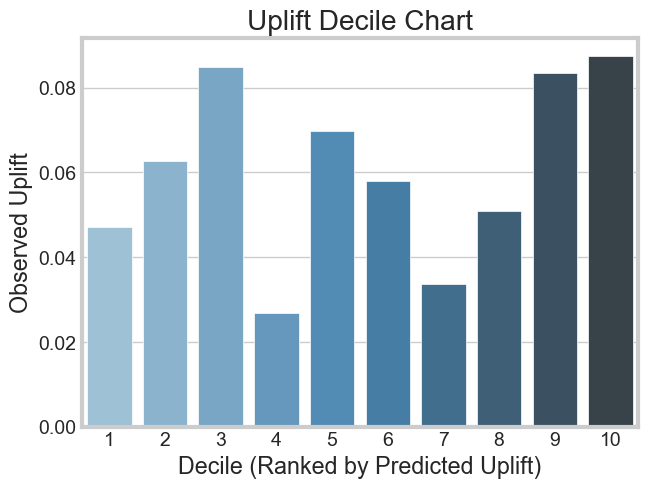

In [109]:
# Plot the observed uplift by decile
sns.barplot(x='decile_tm_rf', y='observed_uplift_tm_rf', data=decile_uplift, palette='Blues_d')
plt.title('Uplift Decile Chart')
plt.xlabel('Decile (Ranked by Predicted Uplift)')
plt.ylabel('Observed Uplift')
plt.show()

This is terrible

### Fake Qini Curve

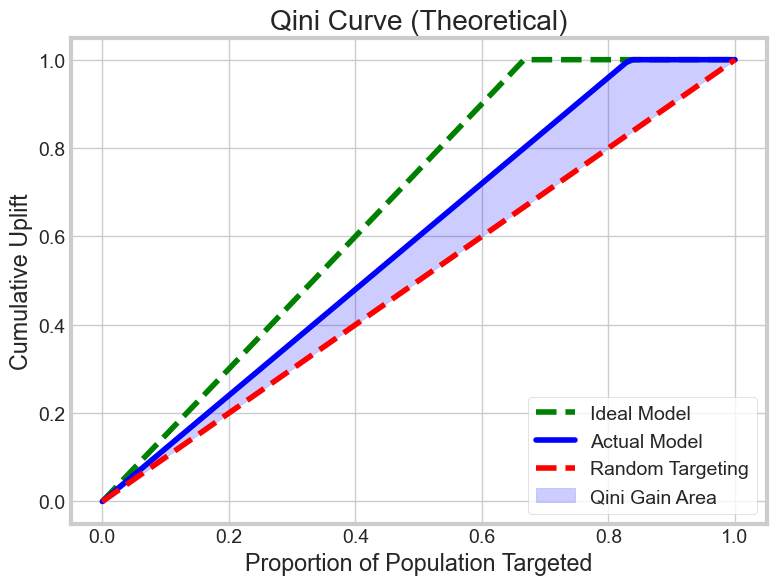

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Create data for a Qini curve
population_targeted = np.linspace(0, 1, 100)  # Proportion of population targeted (X-axis)
random_gain = population_targeted  # Baseline (random targeting)
ideal_gain = np.minimum(population_targeted * 1.5, 1.0)  # Ideal model (optimistic upper bound)
model_gain = np.minimum(population_targeted * 1.2, 1.0)  # Typical uplift model

# Plot the Qini curve
plt.figure(figsize=(8, 6))
plt.plot(population_targeted, ideal_gain, label="Ideal Model", linestyle="--", color="green")
plt.plot(population_targeted, model_gain, label="Actual Model", color="blue")
plt.plot(population_targeted, random_gain, label="Random Targeting", linestyle="--", color="red")
plt.fill_between(population_targeted, random_gain, model_gain, color="blue", alpha=0.2, label="Qini Gain Area")

# Customize plot
plt.title("Qini Curve (Theoretical)")
plt.xlabel("Proportion of Population Targeted")
plt.ylabel("Cumulative Uplift")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### Qini Curve from Kaggle

In [111]:
results_df['target_class'] = 0  # Initialize column
results_df.loc[(results_df['treatment'] == 0) & (results_df['y_true'] == 1), 'target_class'] = 1
results_df.loc[(results_df['treatment'] == 1) & (results_df['y_true'] == 0), 'target_class'] = 2
results_df.loc[(results_df['treatment'] == 1) & (results_df['y_true'] == 1), 'target_class'] = 3

In [112]:
results_df.head()

,y_true,treatment,uplift_tm_rf,uplift_tm_xg,uplift_sm_rf,uplift_sm_xg,decile_tm_rf,target_class
56677,0,1,0.197806,0.195929,0.138763,0.110395,10,2
47079,0,1,0.197806,0.195929,0.138763,0.110395,10,2
32175,0,1,0.197806,0.195929,0.138763,0.110395,10,2
63890,1,1,0.197806,0.195929,0.138763,0.110395,10,3
9992,1,1,0.197806,0.195929,0.138763,0.110395,10,3


In [113]:
def qini_rank(uplift: pd.DataFrame, uplift_score: str) -> pd.DataFrame:
    """Rank the data by the uplift score for a specific model."""
    ranked = uplift[['target_class', uplift_score]].copy()
    ranked.rename(columns={uplift_score: 'uplift_score'}, inplace=True)

    # Add proportion
    ranked['n'] = ranked['uplift_score'].rank(pct=True, ascending=False)

    # Data Ranking
    ranked = ranked.sort_values(by='n').reset_index(drop=True)
    return ranked

In [114]:
def qini_eval(ranked: pd.DataFrame) -> pd.DataFrame:
    """Evaluate the uplift value with the QINI criterion."""
    uplift_model = ranked.copy()
    random_model = ranked.copy()

    # Calculate cumulative gains for treatment and control groups
    C = sum(ranked['target_class'] <= 1)  # Total control group
    T = sum(ranked['target_class'] >= 2)  # Total treatment group
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1, 'cr'] = 1
    ranked.loc[ranked.target_class == 3, 'tr'] = 1
    ranked['cr/c'] = ranked['cr'].cumsum() / C
    ranked['tr/t'] = ranked['tr'].cumsum() / T

    # Calculate uplift for the model and random targeting
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'], 5)
    random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1], 5)

    # Add q0 for initial point
    q0 = pd.DataFrame({'n': [0], 'uplift': [0], 'target_class': [None]})
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop=True)
    random_model = pd.concat([q0, random_model]).reset_index(drop=True)

    # Add model names and combine
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop=True)
    return merged


In [115]:
def qini_plot(merged: pd.DataFrame):
    """Plot QINI curves for multiple models."""
    sns.set_style('whitegrid')

    # Plot the data
    ax = sns.lineplot(
        x='n', y='uplift', hue='model', data=merged, style='model', palette='Set2'
    )

    # Customize plot settings
    plt.xlabel('Proportion Targeted', fontsize=15)
    plt.ylabel('Uplift', fontsize=15)
    plt.title('Qini Curves for Multiple Models', fontsize=16)
    plt.legend(fontsize=12)
    ax.tick_params(labelsize=12)
    plt.grid(True)
    plt.show()
    return ax

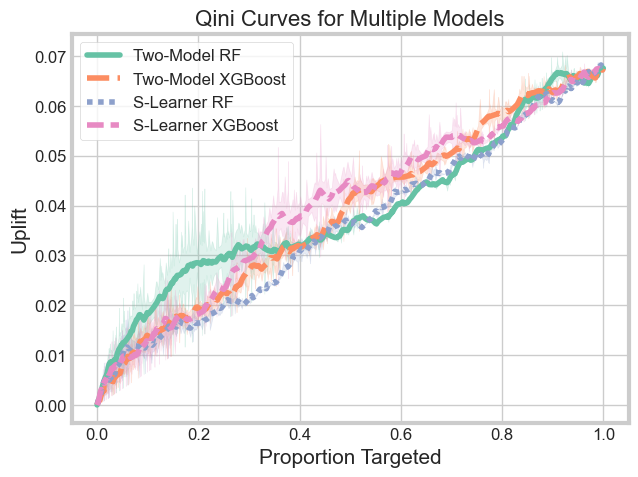

<Axes: title={'center': 'Qini Curves for Multiple Models'}, xlabel='Proportion Targeted', ylabel='Uplift'>

In [116]:
# Combine QINI results for all models
merged_results = pd.DataFrame()

# List of uplift columns for different models
uplift_columns = ['uplift_tm_rf', 'uplift_tm_xg', 'uplift_sm_rf', 'uplift_sm_xg']
model_names = ['Two-Model RF', 'Two-Model XGBoost', 'S-Learner RF', 'S-Learner XGBoost']

for uplift_score, model_name in zip(uplift_columns, model_names):
    ranked = qini_rank(results_df, uplift_score)
    merged = qini_eval(ranked)
    merged['model'] = model_name  # Add model name for identification
    merged_results = pd.concat([merged_results, merged], ignore_index=True)

# Plot all QINI curves
qini_plot(merged_results)

***